<a href="https://colab.research.google.com/github/ConSeanway/invSim/blob/master/InvSim20NOV2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Base Stock Inventory Simulation
## Authors:  Sean Conway + Yanzhe Ma

---

Summer 2020 - Fall 2020 Semester

Last Modified: 29OCT2020

> Implementation of Inventory Simulation Using Classes



In [ ]:
import numpy as np
import pandas as pd
import pprint
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections.abc import Iterable
import random

def iterable(obj):
    return isinstance(obj, Iterable)

Inventory Simulation Class


Basically, we need to force the inventory position to be equal to the base stock level

Ex:  Node 1 and Node 2 have base stock levels of 30 and 60, respectively.
Node 0 is a predecessor to both nodes and has a base stock level of 60.

Node 0 experiences demand of 60.  It fulfills this demand with the 60 base stock it has, and places an order on node 1 for 60 units and places an order on node 2 for 60 units

Node 2 is able to fulfill, but node 1 is only able to fulfill 30 of the units

Each orders 60 units


In [ ]:
# This was for the old 3-node series simulation
df = pd.read_csv("3_node_60_60_60.csv")
print(df["IS 3 Node"][len(df["IS 3 Node"])-1])


In [ ]:
# 3-node triangle case
andCaseSnyderData = pd.read_csv("3stageSim.csv")
print(andCaseSnyderData['IO:EXT'][0])
andCaseSnyderData.head()

40.82375026771819


,t,|i=0,IO:EXT,IOPL:EXT,OQ:1,OQ:2,OO:1,OO:2,IS:1,IS:2,ISPL:1,ISPL:2,RM:1,RM:2,OS:EXT,DMFS,FR,IL,HC,SC,ITHC,TC,|i=1,IO:0,IOPL:0,OQ:EXT,OO:EXT,IS:EXT,ISPL:EXT,RM:EXT,OS:0,DMFS.1,FR.1,IL.1,HC.1,SC.1,ITHC.1,TC.1,|i=2,IO:0.1,IOPL:0.1,OQ:EXT.1,OO:EXT.1,IS:EXT.1,ISPL:EXT.1,RM:EXT.1,OS:0.1,DMFS.2,FR.2,IL.2,HC.2,SC.2,ITHC.2,TC.2
0,0,|,40.823750,[0],100.823750,100.823750,100.823750,100.823750,0.000000,0.000000,"[0, 0.0, 0]","[0, 0.0, 0]",0.0,0.00000,0.00000,0.000000,0.000000,-40.823750,0.000000,408.237503,0.0,408.237503,|,100.823750,[0],150.823750,150.823750,0.000000,"[0, 150.8237502677182, 0]",0.0,0.000000,0.000000,0.000000,-100.823750,0.000000,1008.237503,0.000000,1008.237503,|,100.823750,[0],160.823750,160.823750,0.000000,"[0, 160.8237502677182, 0]",0.0,0.000000,0.000000,0.000000,-100.823750,0.000000,1008.237503,0.000000,1008.237503
1,1,|,52.147390,[0],52.147390,52.147390,152.971140,152.971140,0.000000,0.000000,"[0, 150.8237502677182, 0]","[0, 152.9711399236682, 0]",0.0,0.00000,0.00000,0.000000,0.000000,-92.971140,0.000000,929.711399,0.0,929.711399,|,52.147390,[0],52.147390,52.147390,150.823750,"[0, 52.14738965595002, 0]",0.0,150.823750,50.000000,0.326859,-2.147390,0.000000,21.473897,1508.237503,1529.711399,|,52.147390,[0],52.147390,52.147390,160.823750,"[0, 52.14738965595002, 0]",0.0,152.971140,52.147390,0.340897,7.852610,78.526103,0.000000,1529.711399,1608.237503
2,2,|,79.190409,[0],79.190409,79.190409,81.337799,79.190409,150.823750,152.971140,"[0, 52.14738965595002, 0]","[0, 60.0, 0]",0.0,2.14739,150.82375,57.852610,0.336037,-21.337799,21.473897,213.377987,0.0,234.851884,|,79.190409,[0],79.190409,79.190409,52.147390,"[0, 79.19040905256304, 0]",0.0,52.147390,50.000000,0.430735,-29.190409,0.000000,291.904091,521.473897,813.377987,|,79.190409,[0],79.190409,79.190409,52.147390,"[0, 79.19040905256304, 0]",0.0,60.000000,60.000000,0.483058,-19.190409,0.000000,191.904091,600.000000,791.904091
3,3,|,61.856017,[0],61.856017,61.856017,91.046426,81.046426,52.147390,60.000000,"[0, 79.19040905256304, 0]","[0, 79.19040905256304, 0]",0.0,10.00000,52.14739,30.809591,0.378870,-31.046426,100.000000,310.464257,0.0,410.464257,|,61.856017,[0],61.856017,61.856017,79.190409,"[0, 61.8560166173093, 0]",0.0,79.190409,50.000000,0.510174,-11.856017,0.000000,118.560166,791.904091,910.464257,|,61.856017,[0],61.856017,61.856017,79.190409,"[0, 61.8560166173093, 0]",0.0,79.190409,60.000000,0.585500,-1.856017,0.000000,18.560166,791.904091,810.464257
4,4,|,36.701104,[0],36.701104,36.701104,48.557121,38.557121,79.190409,79.190409,"[0, 48.55712103533197, 0]","[0, 38.55712103533198, 0]",0.0,10.00000,67.74753,36.701104,0.463076,11.442879,214.428790,0.000000,0.0,214.428790,|,36.701104,[0],36.701104,36.701104,61.856017,"[0, 36.70110441802269, 0]",0.0,48.557121,36.701104,0.564531,13.298896,132.988956,0.000000,485.571210,618.560166,|,36.701104,[0],36.701104,36.701104,61.856017,"[0, 36.70110441802269, 0]",0.0,38.557121,36.701104,0.631499,23.298896,232.988956,0.000000,385.571210,618.560166


## Class Implementations

### Inventory Simulation Class

In [ ]:
# "Game" class that can be created to run the whole simulation
class InvSimulation:
  def __init__(self, periodsToSimulate=200):
    self.periodsToSimulate = periodsToSimulate

    # Contains all of the nodes in our simulation (reference by ID)
    self.nodeDict = {}

#- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

# Node - related methods

  def createNode(self, nodeID, h, p, nodeType="retailer", demandMean=0, demandStDev=0, alpha=0.2, beta=0.8):
    '''
    Creates a node to be used in our supply network
    In:  InvSim object, nodeID, h, p, nodeType, demandMean, demandStDev
    '''
    self.nodeDict[nodeID] = Node(nodeID, h, p, nodeType,demandMean, demandStDev, alpha, beta)
  
  #links together two nodes in preDict and recDict; could add a boolean later for linking both ways
  def linkNode(self,startNode,endNode,relationshipType="or"):

    '''
    Create a unidirectional link between nodes
    In: InvSim object, starting Node index, ending Node index

    recDict[] maps one starting node to all of its receiving nodes
    preDict[] maps one ending node to all of its predecessor nodes
    '''
    
    if startNode in self.nodeDict[startNode].recDict.keys():
      self.nodeDict[startNode].recDict[startNode].append(endNode)
    else:
      self.nodeDict[startNode].recDict[startNode] = []
      self.nodeDict[startNode].recDict[startNode].append(endNode)
    
    if endNode in self.nodeDict[endNode].preDict.keys():
      self.nodeDict[endNode].preDict[endNode].append(startNode)
    else:
      self.nodeDict[endNode].preDict[endNode] = []
      self.nodeDict[endNode].preDict[endNode].append(startNode)
  
  #This method adds in all of the combinations of nodeID and the number of units needed to produce one unit for "thisNode"
  def addAndRelationship(self,upstreamNodeID,downstreamNodeID,numNeeded):
    thisNode = self.nodeDict[upstreamNodeID]
    if (upstreamNodeID,downstreamNodeID) not in thisNode.ANDDict.keys():
      thisNode.ANDDict[(upstreamNodeID,downstreamNodeID)] = []
    thisNode.ANDDict[(upstreamNodeID,downstreamNodeID)].append(numNeeded)


#- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

  def playSimulation(self, gameType="multiNodeVerify", BSLevel=60, demandMethod="useFileDemand", fileDemand=[], seed="N/A", connectionCase="or", customDemand = 60, printOut=True):
    '''
    Play the simulation, given the following:
    - game type (string) (default="multiNodeVerify)
    - base stock level (integer for multiNodeVerify game), single value for all nodes (default=60)
    '''

    if gameType == "multiNodeVerify":
      if demandMethod == "useFileDemand":
        self.multiNodeVerify(demandArray=fileDemand, BSLevel=BSLevel, connectionCase=connectionCase, demandMethod=demandMethod, printOut=printOut, gameType=gameType)
      elif demandMethod == "useRandomDemand":
        self.multiNodeVerify(BSLevel=BSLevel, connectionCase=connectionCase, demandMethod=demandMethod, seed=seed, printOut=printOut, gameType=gameType)
    elif gameType == "supplyDisruption":
      if demandMethod == "useFileDemand":
        self.supplyDisrupt(demandArray=fileDemand, BSLevel=BSLevel, connectionCase=connectionCase, demandMethod=demandMethod, customDemand = customDemand, seed=seed, printOut=printOut, gameType=gameType)
      elif demandMethod == "customDemand":
        customDemandArr = [customDemand]*self.periodsToSimulate
        self.supplyDisrupt(demandArray=customDemandArr, BSLevel=BSLevel, connectionCase=connectionCase, demandMethod=demandMethod, customDemand = customDemand, seed=seed, printOut=printOut, gameType=gameType)
    else:
      self.playOptimalBaseStockGame()

#- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
  def printEndStats(self, nodeID, thisNode, period):
      '''
      Print the resulting statistics for a node in the game
      In:
      - nodeID (integer)
      - thisNode (node Object)
      - period (integer)
      '''

      print("Node " + str(nodeID))
      print("(IL) Starting Inventory record for node " + str(nodeID) + ":" + str(thisNode.startingInventoryRecord))
      print("(IS) Inbound supply record for node " + str(nodeID) + ":" + str(thisNode.receivedMats))
      print("(IO) Demand for node " + str(nodeID) + ":" + str(thisNode.demandArray))
      print("(OQ) Order for node " + str(nodeID) + ":" + str(thisNode.orderArray))
      print("(DMFS) Supply for node " + str(nodeID) + ":" + str(thisNode.supplyArray))
      print("(EIL) Ending Inventory record for node " + str(nodeID) + ":" + str(thisNode.endingInventoryRecord))
      print("(BO) Backorders for node " + str(nodeID) + ":" + str(thisNode.backorderRecord))
      print("(TC) Total Cost for node " + str(nodeID) + ":" + str(thisNode.costRecord))
      print()

  def getReceivedMaterialsOrCase(self, nodeID, thisNode, period):
    '''
    Get the number of inbound materials from what the preceding node was able to supply

    Example:
    Flow of material
    o -> o

    Suppose the left node represents a wholesaler, and the right node represents a retailer
    How much material was the wholesaler able to supply to the retailer?

    In:
    - nodeID (dictionary key)
    - period (integer)

    Out:
    - number of received materials (numeric)
    '''

    # Get the number of inbound materials from what the previous node was able to supply
    receivedMatsNum = 0
    upstreamNum= 0
    upstreamList = []

    # First period, you shouldn't be receiving anything
    if period == 0:
      thisNode.receivedMats.append(receivedMatsNum)
      return receivedMatsNum


    # If a node has no receivers, we assume that it'll always be supplied the qty it wants
    if len(self.nodeDict[nodeID].recDict) == 0:
      if iterable(self.nodeDict[nodeID].orderArray[period - 1]):
        #receivedMatsNum = max(self.nodeDict[nodeID].orderArray[period - 1].sum(), 0)
        receivedMatsNum = self.nodeDict[nodeID].orderArray[period - 1].sum()
      else:
        #receivedMatsNum = max(self.nodeDict[nodeID].orderArray[period - 1], 0)
        receivedMatsNum = self.nodeDict[nodeID].orderArray[period - 1]

    #For every node that's not the end supplier 
    elif len(self.nodeDict[nodeID].recDict) != 0:
      #Step 1: get the number of upstream nodes
      upstreamList = self.nodeDict[nodeID].recDict[nodeID]
      for upstreamNode in upstreamList:
        #Step 2: For every upstream node, find out the total number of downstream nodes
        downstreamNum = len(self.nodeDict[upstreamNode].preDict[upstreamNode])
        #Step 3: For every upstream node, find out the total number of finished materials that could be delievered downstream
        totFinishedMatsNum = self.nodeDict[upstreamNode].supplyArray[period-1]
        #The number of finished goods that could be delivered to this particular node = total finished goods/total number of downstream nodes
        finishedMatsNum = totFinishedMatsNum/downstreamNum
        #Sum up all such finished goods received from upstream nodes to get the total number of received materials
        receivedMatsNum += finishedMatsNum

    
    thisNode.receivedMats.append(receivedMatsNum)
    return receivedMatsNum
  
  def getReceivedMaterialsANDCase(self, nodeID, thisNode, period):
    '''
    Get the number of inbound materials from what the preceding node was able to supply

    Example:
    Flow of material
    o -> o

    Suppose the left node represents a wholesaler, and the right node represents a retailer
    How much material was the wholesaler able to supply to the retailer?

    In:
    - nodeID (dictionary key)
    - period (integer)

    Out:
    - number of received materials (numeric)
    '''

    # Get the number of inbound materials from what the previous node was able to supply
    receivedMatsNum = 0
    upstreamNum= 0
    upstreamList = []
    #finishedMatsDict = {}
    suppliableList = []
    spareNum = 0

    # Period 0 case
    if period == 0:
      thisNode.receivedMats.append(receivedMatsNum)
      return receivedMatsNum

    
    # (Not Node 0 case)...  We aren't receiving materials from other nodes (we have factories in this node)
    # Ex:  In triangle example, this is for nodes 1 and 2
    if len(self.nodeDict[nodeID].recDict) == 0:
      # You basically just receive what you ordered last period
      if iterable(self.nodeDict[nodeID].orderArray[period - 1]):
        receivedMatsNum = self.nodeDict[nodeID].orderArray[period - 1].sum()
      else:
        receivedMatsNum = self.nodeDict[nodeID].orderArray[period - 1]
      thisNode.receivedMats.append(receivedMatsNum)
      return receivedMatsNum
    
    # End supplier case
    # To be more specific, this is node 0 (retailer) in the triangle example
    #Step 1: get the number of upstream nodes (why are we still using recDict and preDict...  These are awful names)
    upstreamList = self.nodeDict[nodeID].recDict[nodeID]

    # Go through each of the nodes in the upstream node list (by ID)
    for upstreamNodeID in upstreamList:
      # You can pull the specific node with the node ID (calling on inventory simulation)
      upstreamNode = self.nodeDict[upstreamNodeID]

      #Step 2: For every upstream node, find out the total number of downstream nodes
      downstreamNum = len(upstreamNode.preDict[upstreamNodeID])

      #Step 3: For every upstream node, find out the total number of finished materials that could be delievered downstream
      # NOTE:  Data in the supply array is just how much that predecessor node was able to supply of the main demand in the previous period (not including backorders)
      totFinishedMatsNum = upstreamNode.supplyArray[period - 1]
      # Also get the number of backorders...  We need to find out how many were fulfilled
      totFinishedBackordersNum = upstreamNode.backordersFulfilledArray[period - 1]

      #The number of finished goods that could be delivered to this particular node = total finished goods/total number of downstream nodes
      # Same thing for backorders that were fulfilled
      finishedMatsNum = totFinishedMatsNum / downstreamNum
      finishedBackordersNum = totFinishedBackordersNum / downstreamNum

      # Initialize the finished mats dict if it doesn't already exist
      if upstreamNodeID not in upstreamNode.finishedMatsDict.keys():
        upstreamNode.finishedMatsDict[upstreamNodeID] = 0
      upstreamNode.finishedMatsDict[upstreamNodeID] += finishedMatsNum

      # Don't forget to add the backorders we completed!
      upstreamNode.finishedMatsDict[upstreamNodeID] += finishedBackordersNum

      suppliableList.append(upstreamNode.finishedMatsDict[upstreamNodeID])

    #AND Relationship: find out the minimum of all finishedMatsNum 
    receivedMatsNum = min(suppliableList)

    # Decrement each of the predecessor material dicts by the number of materials you're receiving from it
    for upstreamNodeID in upstreamList:
      self.nodeDict[upstreamNodeID].finishedMatsDict[upstreamNodeID] -= receivedMatsNum

    thisNode.receivedMats.append(receivedMatsNum)
    return receivedMatsNum
    

  def computeDemandOrCase(self, nodeID, thisNode, demandArray, demandMethod, period):
    '''
    Compute the demand for a given node (using a demand array as reference)
    In:
    - nodeID (dictionary Key)
    - thisNode (Node)
    - demandArray (array of numerics)
    - period (integer)
    '''
    downstreamNum = 0
    downstreamList = []
    downstreamNodeDemand = 0
    totDemand = 0
    demandUpstreamNum = 0
    
    # Pull demand from the demand array if it's the retailer
    # Upstream nodes look at what the previous node's order was (that is in turn their demand)
    ### THIS WILL ALSO NEED TO CHANGE TO BE GENERALIZABLE TO THE MULTI-RETAILER CASE
    # if nodeID == 0:
    if len(thisNode.preDict) == 0:
      if demandMethod == "useFileDemand"  or demandMethod == "customDemand":
        totDemand = demandArray[period]
      else:
        totDemand = np.random.normal(loc=thisNode.demandMean, scale=thisNode.demandStDev)
    else:
      #Step 1: get the number of downstream nodes this node has 
      downstreamList = thisNode.preDict[nodeID]
      downstreamNum = len(downstreamList)
      #Step 2: Calculate the number of units demanded for each downstream node
      for downstreamNode in downstreamList:
        #Step 3: find out the number of upstream nodes for the current downstream node
        demandUpstreamNum = len(self.nodeDict[downstreamNode].recDict[downstreamNode])
        #Find out this downstream node's total demand for this period (assuming no delay in placing orders to upstream nodes)
        downstreamNodeDemand = self.nodeDict[downstreamNode].orderArray[period]
        #This node's demand from the current downstream node = total demand/#upstream nodes for this downstream node
        thisNodeDemand = downstreamNodeDemand/demandUpstreamNum
        #Sum up all demands to get the total demand for this node
        totDemand += thisNodeDemand

    #print("Node " + str(thisNode.id))
    #print("Demand " + str(totDemand))
    #print()

    # Incur the demand by appending it to the node's demand array (this is basically just being pulled from the file)
    thisNode.demandArray.append(totDemand)
    return totDemand

  def computeDemandAndCase(self, nodeID, thisNode, demandArray, demandMethod, period):
    '''
    Compute the demand for a given node (using a demand array as reference)
    In:
    - nodeID (dictionary Key)
    - thisNode (Node)
    - demandArray (array of numerics)
    - period (integer)
    '''
    downstreamNum = 0
    downstreamList = []
    downstreamNodeDemand = 0
    totDemand = 0
    demandUpstreamNum = 0
    
    # Pull demand from the demand array if it's the retailer
    # Upstream nodes look at what the previous node's order was (that is in turn their demand)
    # THIS IS CHANGED
    # if nodeID == 0
    if len(thisNode.preDict) == 0:
      if demandMethod == "useFileDemand" or demandMethod == "customDemand":
        totDemand = demandArray[period]
      else:
        totDemand = np.random.normal(loc=thisNode.demandMean, scale=thisNode.demandStDev)
    else:
      #Step 1: get the number of downstream nodes this node has 
      downstreamList = thisNode.preDict[nodeID]
      downstreamNum = len(downstreamList)
      #Step 2: Calculate the number of units demanded for each downstream node
      for downstreamNode in downstreamList:       
        #Find out this downstream node's total demand for this period (assuming no delay in placing orders to upstream nodes)
        downstreamNodeDemand = self.nodeDict[downstreamNode].orderArray[period]    
        #Sum up all demands to get the total demand for this node
        totDemand += downstreamNodeDemand

    # Incur the demand by appending it to the node's demand array (this is basically just being pulled from the file)
    thisNode.demandArray.append(totDemand)
    return totDemand

  def satisfyDemand(self, receivedMats, thisNode, thisPeriodDemand, backordersFulfilled):

    '''
    Given the demand, as well as the supply for a node for a current period, compute
    how much of this node's demand can be supplied (and how many backorders result)

    Record this information in the node

    In:
    - Received materials (numeric)
    - node object (Node)
    - demand for this period (numeric)
    spareUnitsdict(key = (downStream node ID, period), value = (node ID, amount of units left)


    '''

  # If starting inv is negative...  We have backorders
  # If backorders are fulfilled, receivedMats >= 0
  # If starting inv is positive, no backorders, receivedMats also >= 0
  # We should never be "punished" twice for having a negative starting inventory
  # In no instance should this ever go negative
    availableSupply = max(receivedMats + max(thisNode.startingInventory,0),0)

    # Record demand that can be supplied, along with the backorders that were fulfilled
    if iterable(thisPeriodDemand):
      totDemand = thisPeriodDemand.sum()
    totDemand = thisPeriodDemand
    suppliableDemand = min(availableSupply, totDemand)
    # OLD VERSION:  thisNode.supplyArray.append(suppliableDemand + backordersFulfilled)
    # Reason for change:  Causing "double fulfillment" of backorders (not sure about this yet) - Sean
    thisNode.supplyArray.append(suppliableDemand)
    thisNode.backordersFulfilledArray.append(backordersFulfilled)



  def computeEIAndCosts(self, thisNode, thisPeriodDemand, receivedMats, backordersFulfilled, gameType):
    '''
    Compute ending inventory and costs
    '''
    
    # Need to add the number of backorders fulfilled back in...  This is because we've already decremented receivedMats
    # Received mats is not the total number of received materials this period.  It is the number of received materials, less backorders fulfilled

    if iterable(thisPeriodDemand):
      #thisNode.endingInventory = thisNode.startingInventory - thisPeriodDemand.sum() + thisNode.finishedMatsDict[thisNode.nodeID] + receivedMats + backordersFulfilled
      thisNode.endingInventory = thisNode.startingInventory - thisPeriodDemand.sum() + receivedMats + backordersFulfilled
    else:
      thisNode.endingInventory = thisNode.startingInventory - thisPeriodDemand + receivedMats + backordersFulfilled

    # Order the same quantity as the demand from this period
    if gameType == "supplyDisruption":
      if thisNode.state == 'up':
        # Maybe this is right???  Look a little more into this
        #qtyToOrder = thisNode.baseStockLevel - thisNode.endingInventory

        if iterable(thisPeriodDemand):
          qtyToOrder = thisPeriodDemand.sum() + thisNode.cumuDemandCount
        else:
          qtyToOrder = thisPeriodDemand + thisNode.cumuDemandCount
        thisNode.cumuDemandCount = 0

      elif thisNode.state == 'down':
        if iterable(thisPeriodDemand):
          thisNode.cumuDemandCount += thisPeriodDemand.sum()
        else:
          thisNode.cumuDemandCount += thisPeriodDemand
        qtyToOrder = 0
    else:
      qtyToOrder = thisPeriodDemand

    #qtyToOrder = thisPeriodDemand
    thisNode.orderArray.append(qtyToOrder)

    thisNode.backorders = -1 * min(0, thisNode.endingInventory)
    thisNode.backorderRecord.append(thisNode.backorders)

    finishedMatsSum = 0
    for i in thisNode.finishedMatsDict:
      finishedMatsSum += thisNode.finishedMatsDict[i]
    thisPeriodCost = max(0,thisNode.endingInventory*thisNode.holdingCost) + max(0,-1*thisNode.endingInventory*thisNode.stockoutCost) + (finishedMatsSum*thisNode.holdingCost)
    thisNode.endingInventoryRecord.append(thisNode.endingInventory)
    thisNode.holdingCostRecord.append(max(0,(thisNode.endingInventory)*thisNode.holdingCost) + (finishedMatsSum*thisNode.holdingCost))
    thisNode.stockoutCostRecord.append(max(0,-1*thisNode.endingInventory*thisNode.stockoutCost))
    thisNode.costRecord.append(thisPeriodCost)


  def getPdToSimulate(self, demandArray):
    availablePdToSimulate = 0
    if len(demandArray) == 0:
       availablePdToSimulate = self.periodsToSimulate + 1
    else:
      availablePdToSimulate = len(demandArray)
    return availablePdToSimulate

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

  def supplyDisrupt(self, demandArray=[], BSLevel=60, connectionCase="or", demandMethod="customDemand", customDemand = 60, seed="N/A", printOut=True, gameType="multiNodeVerify"):
  
    '''
    Run instance of the game using a preset demand
    In:
    - demandArray:  array of numerics, containing demand for each node
    - BSLevel: (optional, default=60) Base stock level (numeric)
    '''
    

    # Apply an RN seed if we need one
    if seed != "N/A":
      random.seed(seed)
    if type(BSLevel) == dict:
      # Read the base stock level in from the dictionary
      for nodeID in sorted(self.nodeDict.keys()): self.nodeDict[nodeID].initGame(BSLevel[nodeID])
    else:
      # Reset lists from previous runs
      for nodeID in sorted(self.nodeDict.keys()): self.nodeDict[nodeID].initGame(BSLevel)

    availablePdToSimulate = self.getPdToSimulate(demandArray)

    # Determine order quantity for the current period for all nodes (prior to demand determination)
    for period in range(0, min(availablePdToSimulate, self.periodsToSimulate)):
      for nodeID in sorted(self.nodeDict.keys()):

        thisNode = self.nodeDict[nodeID]

        # Change state depending upon the wheels of fate
        # Alpha is probability of going down
        possibleStates = list(thisNode.transitionProbDict.keys())
        if thisNode.state == 'up':
          newState = random.choices(possibleStates, weights=(1 - thisNode.alpha, thisNode.alpha), k=1)[0]
          thisNode.state = newState
        # Beta represents the probability of going back up
        elif thisNode.state == 'down':
          newState = random.choices(possibleStates, weights=(thisNode.beta, 1-thisNode.beta), k=1)[0]
          thisNode.state = newState

        # Record starting inventory, and get materials from upstream node
        thisNode.startingInventoryRecord.append(thisNode.startingInventory)
        if connectionCase == "and":
          receivedMats = self.getReceivedMaterialsANDCase(nodeID, thisNode, period)
        else:
          receivedMats = self.getReceivedMaterialsOrCase(nodeID, thisNode, period)        

        # Determine how many backorders can be fulfilled
        backordersFulfilled, receivedMatsForThisPd = thisNode.getBackorders(receivedMats)

        # Compute the demand, and satisfy as much of it as we are able (during this period)
        if connectionCase == "and":
          thisPeriodDemand = self.computeDemandAndCase(nodeID, thisNode, demandArray, demandMethod, period)
        else:
          thisPeriodDemand = self.computeDemandOrCase(nodeID, thisNode, demandArray, demandMethod, period)

        self.satisfyDemand(receivedMatsForThisPd, thisNode, thisPeriodDemand, backordersFulfilled)

        # Compute the ending inventory and costs for this period (and print resulting statistics)
        self.computeEIAndCosts(thisNode, thisPeriodDemand, receivedMatsForThisPd, backordersFulfilled, gameType)

        if printOut == True and (period == self.periodsToSimulate - 1):
          self.printEndStats(nodeID, thisNode, period)
        
        # Make the starting inventory equal to ending inventory from previous period
        thisNode.startingInventory = thisNode.endingInventory

      #Write a for loop here to calculate number of units each node was able to supply:
          #for each node, check upstream nodes for each node, divide each node's suppliable units by the ratio of supply (will record later). 
        #Take the min value of the remainder and set that as the min number of units we could supply to this node
        #(for loop) go into each upstream node that isn't the limiting factor, take the remainder after supplying units and add it back to the ending inventory for this upstream node
      #Then go through each node and assess costs

      ### Other changes that will need to happen:
      # Separate the EI computation from the cost computation in the "computeEIAndCosts" method
      # Probably want to print the end stats
      # Set the starting inv - ending inv for all nodes
  
  def multiNodeVerify(self, demandArray=[], BSLevel=60, connectionCase="or", demandMethod="useRandomDemand", seed="N/A", printOut=True, gameType="multiNodeVerify"):

    '''
    Run instance of the game using a preset demand
    In:
    - demandArray:  array of numerics, containing demand for each node
    - BSLevel: (optional, default=60) Base stock level (numeric)
    '''

    # Apply an RN seed if we need one
    if seed != "N/A":
      np.random.seed(seed)

    if type(BSLevel) == dict:
      # Read the base stock level in from the dictionary
      for nodeID in sorted(self.nodeDict.keys()): self.nodeDict[nodeID].initGame(BSLevel[nodeID])
    else:
      # Reset lists from previous runs
      for nodeID in sorted(self.nodeDict.keys()): self.nodeDict[nodeID].initGame(BSLevel)

    availablePdToSimulate = self.getPdToSimulate(demandArray)
      
    # Determine order quantity for the current period for all nodes (prior to demand determination)
    for period in range(0, min(availablePdToSimulate, self.periodsToSimulate)):
      for nodeID in sorted(self.nodeDict.keys()):

        thisNode = self.nodeDict[nodeID]       

        # Record starting inventory, and get materials from upstream node
        thisNode.startingInventoryRecord.append(thisNode.startingInventory)
        if connectionCase == "and":
          receivedMats = self.getReceivedMaterialsANDCase(nodeID, thisNode, period)
        else:
          receivedMats = self.getReceivedMaterialsOrCase(nodeID, thisNode, period)        

        # Determine how many backorders can be fulfilled
        backordersFulfilled, receivedMatsForThisPd = thisNode.getBackorders(receivedMats)

        # Compute the demand, and satisfy as much of it as we are able (during this period)
        if connectionCase == "and":
          thisPeriodDemand = self.computeDemandAndCase(nodeID, thisNode, demandArray, demandMethod, period)
        else:
          thisPeriodDemand = self.computeDemandOrCase(nodeID, thisNode, demandArray, demandMethod, period)

        self.satisfyDemand(receivedMatsForThisPd, thisNode, thisPeriodDemand, backordersFulfilled)

        # Order the same quantity as the demand from this period
        #qtyToOrder = thisPeriodDemand
        #thisNode.orderArray.append(qtyToOrder)

        # Compute the ending inventory and costs for this period (and print resulting statistics)
        self.computeEIAndCosts(thisNode, thisPeriodDemand, receivedMatsForThisPd, backordersFulfilled, gameType)

        if printOut == True and (period == self.periodsToSimulate - 1):
          self.printEndStats(nodeID, thisNode, period)
        
        # Make the starting inventory equal to ending inventory from previous period
        thisNode.startingInventory = thisNode.endingInventory

      #Write a for loop here to calculate number of units each node was able to supply:
          #for each node, check upstream nodes for each node, divide each node's suppliable units by the ratio of supply (will record later). 
        #Take the min value of the remainder and set that as the min number of units we could supply to this node
        #(for loop) go into each upstream node that isn't the limiting factor, take the remainder after supplying units and add it back to the ending inventory for this upstream node
      #Then go through each node and assess costs

      ### Other changes that will need to happen:
      # Separate the EI computation from the cost computation in the "computeEIAndCosts" method
      # Probably want to print the end stats
      # Set the starting inv - ending inv for all nodes
  

      '''
      for each period that's not period 0:
      for every node that's not node 0:
        DONE: step 1: check the demand received at this node
        step 2: calculate order amount = base stock level - ending inventory level (inventory level after the demand has been incurred)
        step 3: place the order accordingly

      for node 0:
        step 1: check the demand received at this node
        step 2: check the number of units received from upstream nodes in this period
        step 3: determine how many units could be supplied by adding up the spare units in inventory and units received
        step 4: take the min of units received from each upstream node
        step 5: store the additional units at node 0's inventory; record which node these units came from
 
 
      '''



### Node Class

In [ ]:
class Node:

  def __init__(self, id, h=3, p=100, nodeType = "retailer",demandMean=50, demandStDev=10, alpha=0, beta=1):

    '''
    Node represents a single node on our supply network
    In:
    - NodeID (required, we recommend using integers 0-inf)
    - h (unit holding cost) (numeric), default = 3
    - p (unit stockout cost) (numeric), default = 100
    - nodeType (description of node type) (string), default = "retailer"
    - demandMean (mean of the demand function) (numeric), default = 50
    - demandStDev (standard deviation of the demand function) (numeric), default = 10

    Note that we are currently assuming normal demands (perhaps specify other distributions if you want)
    '''

    self.id = id
    
    self.holdingCost = h
    self.stockoutCost = p
    self.baseStockLevel = 0

    self.startingInventory = self.baseStockLevel
    self.endingInventory = 0
    
    self.nodeType = nodeType
    self.backorders = 0

    # This is assuming that in this game, we have an idea of the distribution params for demand
    self.demandMean = demandMean
    self.demandStDev = demandStDev

    # Add 2 dictionaries, one for recording recipients and one for predecessors, to each node for cross-node implementations
    self.preDict = {}
    self.recDict = {}
    #Create a dictionary that stores the nodes that have "AND" relationships with the current node
    self.ANDDict = {}

    self.initState = 'up'
    self.state = self.initState
    self.transitionProbDict = {'up': alpha, 'down': beta}
    self.alpha = alpha
    self.beta = beta

    self.cumuDemandCount = 0

  def initGame(self, BSLevel, alpha=0.2, beta=0.8):
    self.demandArray  = []
    self.orderArray = []
    self.supplyArray = []
    self.backordersFulfilledArray = []
    
    self.startingInventoryRecord = []
    self.endingInventoryRecord = []
    self.backorderRecord = []
    self.receivedMats = []
    self.costRecord = []
    self.holdingCostRecord = []
    self.stockoutCostRecord = []
    # Initialize the base stock level for period 0 and beyond, also starting inventory for period 0
    self.startingInventory = BSLevel
    self.baseStockLevel = BSLevel
    self.backorders = 0
    self.endingInventory = 0
    self.finishedMatsDict = {}
    self.cumuDemandCount = 0

    self.initState = 'up'
    self.state = self.initState

  def getBackorders(self, receivedMats):
    backordersFulfilled = 0

    # Serve backorders with the new supply first
    if self.backorders > 0:
      if receivedMats >= self.backorders:
        backordersFulfilled = self.backorders
        self.backorders = 0
        receivedMats = receivedMats - backordersFulfilled
      else:
        backordersFulfilled = receivedMats
        self.backorders = self.backorders - receivedMats
        receivedMats = 0
    return backordersFulfilled, receivedMats

  # New code!!!  - Written by Sean (print method for Node class)
  def __str__(self):
    # Print method for the node class (be able to print out all node fields we're interested in)
    myString = "Node " + str(self.id) + "\n"
    myString += "nodeType = " + str(self.nodeType) + "\n"
    myString += "holdingCost = " + str(self.holdingCost) + "\n"
    myString += "stockoutCost = " + str(self.stockoutCost) + "\n"
    myString += "baseStockLevel = " + str(self.baseStockLevel) + "\n"
    myString += "\nNode Links\n"
    myString += "Predecessor Node IDs = " + str(self.preDict) + "\n"
    myString += "Recipient Node IDs = " + str(self.recDict) + "\n"
    myString += "AND Relationships this Node has = " + str(self.ANDDict) + "\n"
    myString += "\nDemand and Supply\n"
    myString += "demandArray = " + str(self.demandArray) + "\n"
    myString += "orderArray = " + str(self.orderArray) + "\n"
    myString += "supplyArray = " + str(self.supplyArray) + "\n"
    myString += "\nInventory Statistics\n"
    myString += "startingInventoryRecord = " + str(self.startingInventoryRecord) + "\n"
    myString += "endingInventoryRecord = " + str(self.endingInventoryRecord) + "\n"
    myString += "backorderRecord = " + str(self.backorderRecord) + "\n"
    myString += "receivedMats = " + str(self.receivedMats) + "\n"
    myString += "costRecord = " + str(self.costRecord) + "\n"
    myString += "backordersFulfilledArray = " + str(self.backordersFulfilledArray) + "\n\n"
    return myString

##Supply Disruption

In [ ]:
'''when in upstate, has alpha chance to go to down state
when in down state, has beta chance to go to up state
when supplier is up, lead time is zero
when supplier is down, no orders could be placed

Assumptions for Newsvendor Problem with Disruptions 
1. The demand is deterministic and constant, equal to d units per period.
2. The supplier experiences disruptions that are governed by a DTMC.
3. When the supplier is up, the lead time is 0—orders are received instantaneously.
4. When the supplier is down, no orders can be placed.
5. Unmet demands are backordered.
6. There is a single product, or stock-keeping unit (SKU).
'''


'when in upstate, has alpha chance to go to down state\nwhen in down state, has beta chance to go to up state\nwhen supplier is up, lead time is zero\nwhen supplier is down, no orders could be placed\n\nAssumptions for Newsvendor Problem with Disruptions \n1. The demand is deterministic and constant, equal to d units per period.\n2. The supplier experiences disruptions that are governed by a DTMC.\n3. When the supplier is up, the lead time is 0—orders are received instantaneously.\n4. When the supplier is down, no orders can be placed.\n5. Unmet demands are backordered.\n6. There is a single product, or stock-keeping unit (SKU).\n'

## Simulation Run

In [ ]:
myInvSim = InvSimulation(periodsToSimulate=100)

# Node creation:  Key (mandatory), holding cost, stockout cost, and fixed order cost
#myInvSim.createNode(nodeID = 0, h = 10, p = 10, demandMean=50, demandStDev=10, alpha=1, beta=1)
myInvSim.createNode(nodeID = 0, h = 10, p = 10)
myInvSim.createNode(nodeID = 1, h = 10, p = 10)
myInvSim.createNode(nodeID = 2, h = 10, p = 10)
#myInvSim.createNode(nodeID = 3, h = 10, p = 0, demandMean=50, demandStDev=10)

# Node linkage:  start Node Key, end Node Key
myInvSim.linkNode(startNode = 0,endNode = 1)
myInvSim.linkNode(startNode = 0,endNode = 2)
#myInvSim.linkNode(startNode = 1,endNode = 3)
#myInvSim.linkNode(startNode = 2,endNode = 3)
#myInvSim.addAndRelationship(upstreamNodeID = 1,downstreamNodeID = 0, numNeeded=3)
#for i in myInvSim.nodeDict.values(): 
#  pprint.pprint(i.preDict)

#ANDRelationIDList = [2,3]
#myInvSim.addAndRelationship(4,ANDRelationList,)
#print(myInvSim.nodeDict[0].recDict[0])
#print(myInvSim.nodeDict[2].preDict[2])

# Put node ID: base stock level, nextNodeID...
startInvDict = {0: 60, 1: 50, 2: 60}
#startInvDict = {0: 60}


# Currently assume that everyone plays with the same policy
#myInvSim.playSimulation(gameType = "supplyDisruption", BSLevel=startInvDict, demandMethod="customDemand", customDemand = 50, connectionCase="and", seed=404, printOut=True)
#myInvSim.playSimulation(gameType = "multiNodeVerify", BSLevel=startInvDict, demandMethod="useFileDemand", fileDemand=df["IO"], connectionCase="and", printOut=True)
#myInvSim.playSimulation(gameType = "multiNodeVerify", BSLevel=startInvDict, demandMethod="useRandomDemand", seed=60, connectionCase="and", printOut=True)

myInvSim.playSimulation(gameType = "multiNodeVerify", BSLevel=startInvDict, demandMethod="useFileDemand", fileDemand=andCaseSnyderData["IO:EXT"], connectionCase="and", printOut=True)

Node 0
(IL) Starting Inventory record for node 0:[60, 19.17624973228181, 7.852610344049971, -21.33779870851305, -31.04642566987234, 11.442878964667983, 8.468629172711395, -0.4105213532802523, 8.419619186604244, 14.300057681875238, 8.831042191375808, 15.343976566950651, -1.3841739729895437, -9.844232324499274, -6.59628109168802, 15.404576608575368, -1.7492203389964587, 20.684211235683893, 23.496188272952654, -0.36212937972769055, -17.002773520980213, -8.502145490086079, 18.486473893145046, -1.9206440578171566, -16.41906568965247, -26.66335405423696, -12.713389523788265, -1.7758584637679888, -21.465920786576945, -27.54402458156614, -8.014446674736135, 9.624798268021046, 8.348442801899829, 19.30178606380626, -0.36735493794889607, -11.941878277069783, 16.86334141332531, 7.002471503992716, 11.035501567343573, 9.321330364780295, 22.262097888246664, 2.72543453333315, 24.91576697885753, 1.3268761678644125, 23.819564107540664, 17.00786118894814, 9.516744175447506, 2.4918439143198867, -6.8020758

## Alpha/Beta Verification - Completed 11/2/2020

In [ ]:
# Create inventory simulation
myInvSim = InvSimulation(periodsToSimulate=100)

# Set up node tree
myInvSim.createNode(nodeID = 0, h = 10, p = 10, alpha=0, beta=1)
myInvSim.createNode(nodeID = 1, h = 10, p = 10, alpha=0, beta=1)
myInvSim.createNode(nodeID = 2, h = 10, p = 10, alpha=0, beta=1)

myInvSim.linkNode(startNode = 0,endNode = 1)
myInvSim.linkNode(startNode = 0,endNode = 2)

startInvDict = {0: 60, 1: 50, 2: 60}

# Run the simulation
myInvSim.playSimulation(gameType = "supplyDisruption", BSLevel=startInvDict, demandMethod="customDemand", customDemand=60, fileDemand=andCaseSnyderData["IO:EXT"], connectionCase="and", printOut=True)

Node 0
(IL) Starting Inventory record for node 0:[60, 0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0]
(IS) Inbound supply record for node 0:[0, 50.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0,

## Base Stock Level Plots

### 3-node simulation:  Varying node 0's base stock level

In [ ]:
totalCostList = []
baseStockList = []
baseStockTestDict = {0: 60, 1: 60, 2: 30}
for i in range(20,256):
  totalCost = 0
  baseStockTestDict = {0: i, 1: 60, 2: 60}
  
  myInvSim.playSimulation(gameType = "multiNodeVerify", BSLevel=baseStockTestDict, demandMethod="useFileDemand", fileDemand=df["IO"], connectionCase="and", printOut=False)

  for node in myInvSim.nodeDict.values():
    #print(sum(node.costRecord))
    totalCost += sum(node.costRecord)
  totalCostList.append(totalCost)
  baseStockList.append(i)

plt.scatter(baseStockList, totalCostList)
plt.plot(baseStockList, totalCostList)
plt.title("Total Cost vs Base Stock Level for Changing Node 0 Base Stock Level")
plt.xlabel("Base Stock Level")
plt.ylabel("Total Cost")
plt.show()


NameError: ignored

### 3-node simulation:  Modifying node 2's base stock level

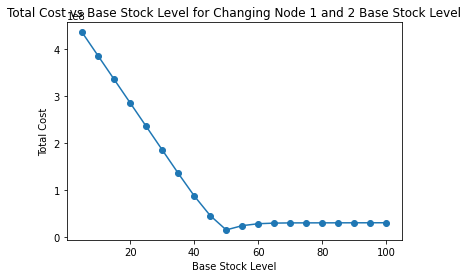

In [ ]:
totalCostList = []
baseStockList = []
baseStockTestDict = {0: 60, 1: 30, 2: 60}
for i in range(5,101,5):
  totalCost = 0
  baseStockTestDict = {0: 60, 1: 50, 2: i}
  
  # Print out 45 and 50 because they be funky
  myInvSim.playSimulation(gameType = "multiNodeVerify", BSLevel=baseStockTestDict, demandMethod="useFileDemand", fileDemand=andCaseSnyderData["IO:EXT"], connectionCase="and", printOut=False)

  for node in myInvSim.nodeDict.values():
    #print(sum(node.costRecord))
    totalCost += sum(node.costRecord)
  totalCostList.append(totalCost)
  baseStockList.append(i)

plt.scatter(baseStockList, totalCostList)
plt.plot(baseStockList, totalCostList)
plt.title("Total Cost vs Base Stock Level for Changing Node 1 and 2 Base Stock Level")
plt.xlabel("Base Stock Level")
plt.ylabel("Total Cost")
plt.show()


### 3-Node 3-D Total Cost vs. Base stock level Surf Plot

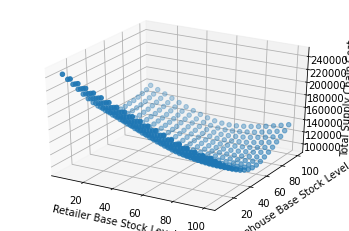

In [ ]:
# FINISHED SEP 22nd, 2020

totalCostList = []
retailerBaseStockList = []
supplierBaseStockList = []
baseStockTestDict = {0: 60, 1: 60, 2: 60}

for j in range(5,101,5):
  for i in range(5,101,5):
    totalCost = 0
    baseStockTestDict = {0: i, 1: j, 2: j}

    # Create inventory simulation
    myInvSim = InvSimulation(periodsToSimulate=100)

    # Set up node tree
    myInvSim.createNode(nodeID = 0, h = 10, p = 10, alpha=0.2, beta=1)
    myInvSim.createNode(nodeID = 1, h = 10, p = 10, alpha=0.2, beta=1)
    myInvSim.createNode(nodeID = 2, h = 10, p = 10, alpha=0.2, beta=1)

    myInvSim.linkNode(startNode = 0,endNode = 1)
    myInvSim.linkNode(startNode = 0,endNode = 2)

    myInvSim.playSimulation(gameType = "supplyDisruption", BSLevel=baseStockTestDict, demandMethod="useFileDemand", fileDemand=andCaseSnyderData["IO:EXT"], connectionCase="and", seed=42, printOut=False)

    #myInvSim.playSimulation(gameType = "supplyDisruption", BSLevel=baseStockTestDict, demandMethod="customDemand", customDemand=60, connectionCase="and", seed=42, printOut=False)

    for node in myInvSim.nodeDict.values():
      totalCost += sum(node.costRecord)
    totalCostList.append(totalCost)
    retailerBaseStockList.append(i)
    supplierBaseStockList.append(j)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.scatter(np.array(retailerBaseStockList), np.array(supplierBaseStockList), np.array(totalCostList))

ax.set_xlabel('Retailer Base Stock Level')
ax.set_ylabel('Warehouse Base Stock Level')
ax.set_zlabel('Total Supply Chain Cost')

plt.show()

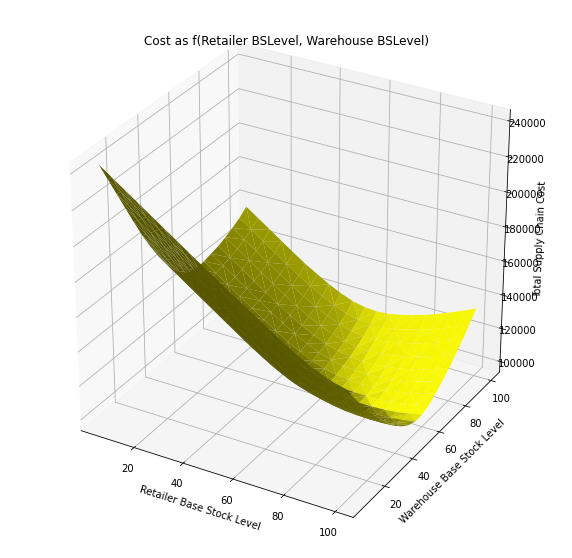

In [ ]:
# 3-D Plot for cost as a function of retailer base stock level and warehouse base stock level
x = np.array(retailerBaseStockList)
y = np.array(supplierBaseStockList)
z = np.array(totalCostList)

fig = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_trisurf(x, y, z, color='yellow')
ax.set_title('Cost as f(Retailer BSLevel, Warehouse BSLevel)')
ax.set_xlabel('Retailer Base Stock Level')
ax.set_ylabel('Warehouse Base Stock Level')
ax.set_zlabel('Total Supply Chain Cost')

fig = plt.gcf()
fig.set_size_inches(10, 10, forward=True)

plt.show()

#### Find the minimum value of the 3-node simulation

In [ ]:
# Find the minimum of the above simulation

minTC = float('inf')
bestRetailerBS = 0
bestWholesalerBS = 0

for i in range(len(totalCostList)):
  if totalCostList[i] < minTC:
    minTC = totalCostList[i]
    bestRetailerBS = retailerBaseStockList[i]
    bestWholesalerBS = supplierBaseStockList[i]

print("Minimum Cost for this simulation")
print("Lowest Cost found: " + str(minTC))
print("Associated Retailer Base Stock Level: " + str(bestRetailerBS))
print("Associated Wholesaler Base Stock Level: " + str(bestWholesalerBS))

Minimum Cost for this simulation
Lowest Cost found: 96680.6698851733
Associated Retailer Base Stock Level: 80
Associated Wholesaler Base Stock Level: 60


### 1-Node simulation (Newsvendor, varying the base stock level)

In [ ]:
# FINISHED SEP 22nd, 2020

totalCostList = []
retailerBaseStockList = []
baseStockTestDict = {0: 60}

for i in range(-100,101):
  totalCost = 0
  baseStockTestDict = {0: i}
  
  myInvSim.playSimulation(gameType = "multiNodeVerify", BSLevel=baseStockTestDict, demandMethod="useFileDemand", fileDemand=andCaseSnyderData["IO:EXT"], connectionCase="or", printOut=False)

  for node in myInvSim.nodeDict.values():
    totalCost += sum(node.costRecord)
  totalCostList.append(totalCost)
  retailerBaseStockList.append(i)

plt.scatter(retailerBaseStockList, totalCostList)

plt.xlabel('Retailer Base Stock Level')
plt.ylabel('Total Supply Chain Cost')

plt.show()

KeyError: ignored

### SC Disruptions:  Changing Alpha and Beta

#### Changing Alpha

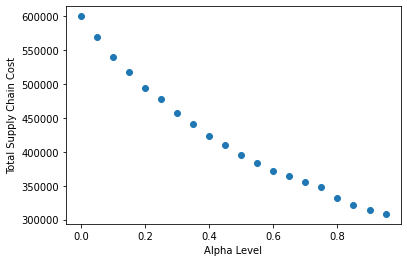

In [ ]:
# FINISHED OCT 26nd, 2020

# FINDING ALPHA

totalCostList = []
alphaList = []
baseStockDict = {0: 120}

# Create an inventory simulation instance, change alpha
for myAlpha in range(0, 100, 5):
  myInvSim = InvSimulation(periodsToSimulate=1000)
  myInvSim.createNode(nodeID = 0, h = 10, p = 10, demandMean=50, demandStDev=10, alpha=myAlpha/100, beta=1)
  totalCost = 0
  
  myInvSim.playSimulation(gameType = "supplyDisruption", BSLevel=baseStockDict, demandMethod="customDemand", customDemand = 60, connectionCase="and", seed=404, printOut=False)

  for node in myInvSim.nodeDict.values():
    totalCost += sum(node.costRecord)
  totalCostList.append(totalCost)
  alphaList.append(myAlpha/100)

plt.scatter(alphaList, totalCostList)

plt.xlabel('Alpha Level')
plt.ylabel('Total Supply Chain Cost')

plt.show()

#### Changing Beta

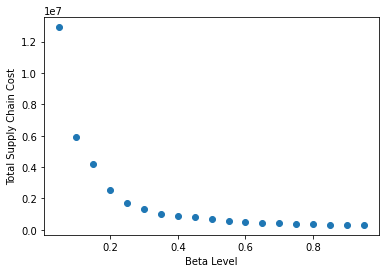

In [ ]:
# FINISHED OCT 26nd, 2020

# FINDING BETA

totalCostList = []
betaList = []
baseStockDict = {0: 120}

# Create an inventory simulation instance, change alpha
for myBeta in range(5, 100, 5):
  myInvSim = InvSimulation(periodsToSimulate=1000)
  myInvSim.createNode(nodeID = 0, h = 10, p = 10, demandMean=50, demandStDev=10, alpha=1, beta=myBeta/100)
  totalCost = 0
  
  myInvSim.playSimulation(gameType = "supplyDisruption", BSLevel=baseStockDict, demandMethod="customDemand", customDemand = 60, connectionCase="and", seed=404, printOut=False)

  for node in myInvSim.nodeDict.values():
    totalCost += sum(node.costRecord)
  totalCostList.append(totalCost)
  betaList.append(myBeta/100)

plt.scatter(betaList, totalCostList)

plt.xlabel('Beta Level')
plt.ylabel('Total Supply Chain Cost')

plt.show()

#### 3-D Plot

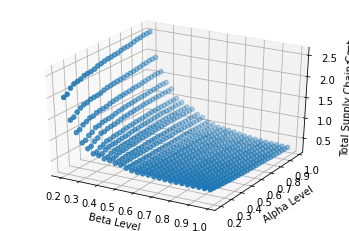

In [ ]:
# FINISHED SEP 22nd, 2020

totalCostList = []
alphaList = []
betaList = []
baseStockDict = {0: 120}

for myAlpha in range(20, 101, 3):
  for myBeta in range(20, 101, 3):

    myInvSim = InvSimulation(periodsToSimulate=1000)
    myInvSim.createNode(nodeID = 0, h = 10, p = 10, demandMean=50, demandStDev=10, alpha=myAlpha/100, beta=myBeta/100)
    totalCost = 0
    
    myInvSim.playSimulation(gameType = "supplyDisruption", BSLevel=baseStockDict, demandMethod="customDemand", customDemand = 60, connectionCase="and", seed=404, printOut=False)

    for node in myInvSim.nodeDict.values():
      totalCost += sum(node.costRecord)
    totalCostList.append(totalCost)
    alphaList.append(myAlpha/100)
    betaList.append(myBeta/100)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.scatter(np.array(betaList), np.array(alphaList), np.array(totalCostList))

ax.set_xlabel('Beta Level')
ax.set_ylabel('Alpha Level')
ax.set_zlabel('Total Supply Chain Cost')

plt.show()

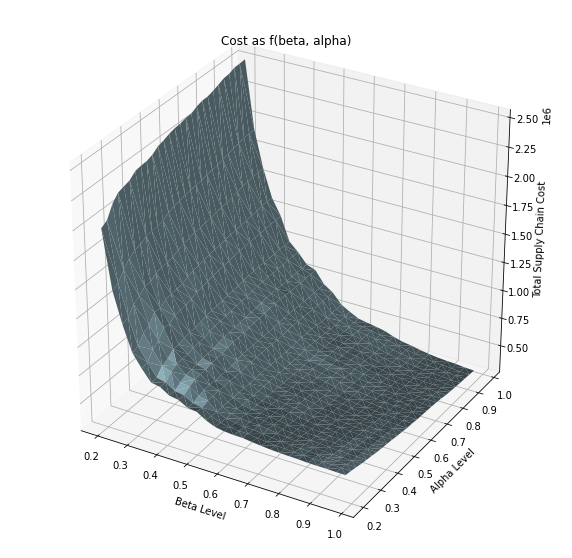

In [ ]:
# 3-D Plot for cost as a function of retailer base stock level and warehouse bse stock level
x = np.array(betaList)
y = np.array(alphaList)
z = np.array(totalCostList)

fig = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_trisurf(x, y, z, color='lightblue')
ax.set_title('Cost as f(beta, alpha)')
ax.set_xlabel('Beta Level')
ax.set_ylabel('Alpha Level')
ax.set_zlabel('Total Supply Chain Cost')

fig = plt.gcf()
fig.set_size_inches(10, 10, forward=True)

plt.show()

## Testing 3-Node Alpha/Beta Simulation

In [ ]:
# FINISHED SEP 22nd, 2020

totalCostList = []
retailerBaseStockList = []
supplierBaseStockList = []
baseStockTestDict = {0: 60, 1: 30, 2: 60}

for j in range(5,201,5):
  for i in range(5,101,5):
    totalCost = 0
    baseStockTestDict = {0: i, 1: j, 2: j}
    
    myInvSim.playSimulation(gameType = "multiNodeVerify", BSLevel=baseStockTestDict, demandMethod="useFileDemand", fileDemand=andCaseSnyderData["IO:EXT"], connectionCase="and", printOut=False)

    #myInvSim.playSimulation(gameType = "multiNodeVerify", BSLevel=baseStockTestDict, demandMethod="useFileDemand", fileDemand=df["IO"], connectionCase="and", printOut=False)

    for node in myInvSim.nodeDict.values():
      totalCost += sum(node.costRecord)
    totalCostList.append(totalCost)
    retailerBaseStockList.append(i)
    supplierBaseStockList.append(j)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.scatter(np.array(retailerBaseStockList), np.array(supplierBaseStockList), np.array(totalCostList))

ax.set_xlabel('Retailer Base Stock Level')
ax.set_ylabel('Warehouse Base Stock Level')
ax.set_zlabel('Total Supply Chain Cost')

plt.show()

In [ ]:
# 3-D Plot for cost as a function of retailer base stock level and warehouse bse stock level
x = np.array(retailerBaseStockList)
y = np.array(supplierBaseStockList)
z = np.array(totalCostList)

fig = plt.figure()
ax = plt.axes(projection='3d',)
surf = ax.plot_trisurf(x, y, z, color='yellow')
ax.set_title('Cost as f(Retailer BSLevel, Warehouse BSLevel)')
ax.set_xlabel('Retailer Base Stock Level')
ax.set_ylabel('Warehouse Base Stock Level')
ax.set_zlabel('Total Supply Chain Cost')

fig = plt.gcf()
fig.set_size_inches(10, 10, forward=True)

plt.show()

In [ ]:
# Find the minimum of the above simulation

minTC = float('inf')
bestRetailerBS = 0
bestWholesalerBS = 0

for i in range(len(totalCostList)):
  if totalCostList[i] < minTC:
    minTC = totalCostList[i]
    bestRetailerBS = retailerBaseStockList[i]
    bestWholesalerBS = supplierBaseStockList[i]

print("Minimum Cost for this simulation")
print("Lowest Cost found: " + str(minTC))
print("Associated Retailer Base Stock Level: " + str(bestRetailerBS))
print("Associated Wholesaler Base Stock Level: " + str(bestWholesalerBS))

## Testing Infrequent long disruptions (low alpha, low beta) vs. frequent short disruptions (high alpha, high beta)

### Assumption:  All nodes are subject to these disruptions


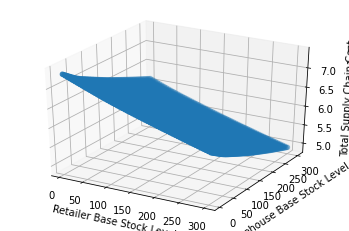

In [ ]:
# FINISHED NOV 15th, 2020

selectedAlpha = 0.12
selectedBeta = 0.08

totalCostList = []
retailerBaseStockList = []
supplierBaseStockList = []
baseStockTestDict = {0: 60, 1: 60, 2: 60}

for j in range(5,301,5):
  for i in range(5,301,5):
    totalCost = 0
    baseStockTestDict = {0: i, 1: j, 2: j}

    # Create inventory simulation
    myInvSim = InvSimulation(periodsToSimulate=100)

    # Set up node tree
    myInvSim.createNode(nodeID = 0, h = 10, p = 50, alpha=selectedAlpha, beta=selectedBeta)
    myInvSim.createNode(nodeID = 1, h = 10, p = 50, alpha=selectedAlpha, beta=selectedBeta)
    myInvSim.createNode(nodeID = 2, h = 10, p = 50, alpha=selectedAlpha, beta=selectedBeta)

    myInvSim.linkNode(startNode = 0,endNode = 1)
    myInvSim.linkNode(startNode = 0,endNode = 2)

    myInvSim.playSimulation(gameType = "supplyDisruption", BSLevel=baseStockTestDict, demandMethod="useFileDemand", fileDemand=andCaseSnyderData["IO:EXT"], connectionCase="and", seed=42, printOut=False)

    #myInvSim.playSimulation(gameType = "supplyDisruption", BSLevel=baseStockTestDict, demandMethod="customDemand", customDemand=60, connectionCase="and", seed=42, printOut=False)

    for node in myInvSim.nodeDict.values():
      totalCost += sum(node.costRecord)
    totalCostList.append(totalCost)
    retailerBaseStockList.append(i)
    supplierBaseStockList.append(j)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.scatter(np.array(retailerBaseStockList), np.array(supplierBaseStockList), np.array(totalCostList))

ax.set_xlabel('Retailer Base Stock Level')
ax.set_ylabel('Warehouse Base Stock Level')
ax.set_zlabel('Total Supply Chain Cost')

plt.show()

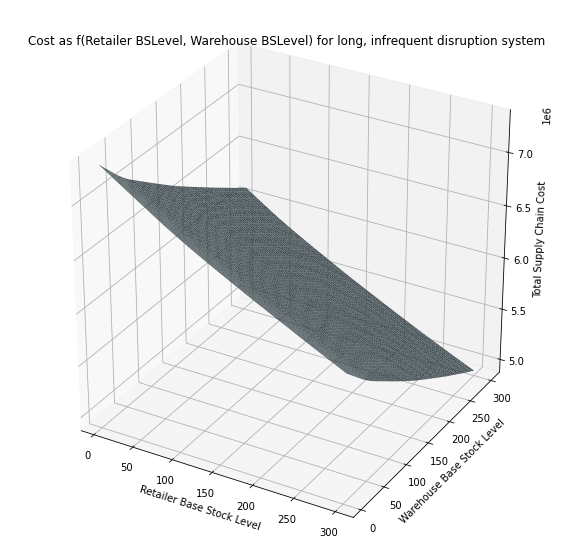

In [ ]:
# 3-D Plot for cost as a function of retailer base stock level and warehouse base stock level
x = np.array(retailerBaseStockList)
y = np.array(supplierBaseStockList)
z = np.array(totalCostList)

fig = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_trisurf(x, y, z, color='lightblue')
ax.set_title('Cost as f(Retailer BSLevel, Warehouse BSLevel) for long, infrequent disruption system')
ax.set_xlabel('Retailer Base Stock Level')
ax.set_ylabel('Warehouse Base Stock Level')
ax.set_zlabel('Total Supply Chain Cost')

fig = plt.gcf()
fig.set_size_inches(10, 10, forward=True)

plt.show()

In [ ]:
# Find the minimum of the above simulation

minTC = float('inf')
bestRetailerBS = 0
bestWholesalerBS = 0

for i in range(len(totalCostList)):
  if totalCostList[i] < minTC:
    minTC = totalCostList[i]
    bestRetailerBS = retailerBaseStockList[i]
    bestWholesalerBS = supplierBaseStockList[i]

print("Minimum Cost for this simulation")
print("Lowest Cost found: " + str(minTC))
print("Associated Retailer Base Stock Level: " + str(bestRetailerBS))
print("Associated Wholesaler Base Stock Level: " + str(bestWholesalerBS))

Minimum Cost for this simulation
Lowest Cost found: 4924281.474078488
Associated Retailer Base Stock Level: 300
Associated Wholesaler Base Stock Level: 300


Frequent Short Disruptions

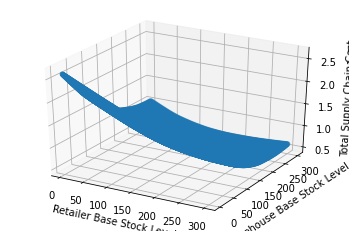

In [ ]:
# FINISHED NOV 15th, 2020

selectedAlpha2 = 0.72
selectedBeta2 = 0.5

totalCostList = []
retailerBaseStockList = []
supplierBaseStockList = []
baseStockTestDict = {0: 60, 1: 60, 2: 60}

for j in range(4,301,2):
  for i in range(4,301,2):
    totalCost = 0
    baseStockTestDict = {0: i, 1: j, 2: j}

    # Create inventory simulation
    myInvSim = InvSimulation(periodsToSimulate=100)

    # Set up node tree
    myInvSim.createNode(nodeID = 0, h = 10, p = 50, alpha=selectedAlpha2, beta=selectedBeta2)
    myInvSim.createNode(nodeID = 1, h = 10, p = 50, alpha=selectedAlpha2, beta=selectedBeta2)
    myInvSim.createNode(nodeID = 2, h = 10, p = 50, alpha=selectedAlpha2, beta=selectedBeta2)

    myInvSim.linkNode(startNode = 0,endNode = 1)
    myInvSim.linkNode(startNode = 0,endNode = 2)

    myInvSim.playSimulation(gameType = "supplyDisruption", BSLevel=baseStockTestDict, demandMethod="useFileDemand", fileDemand=andCaseSnyderData["IO:EXT"], connectionCase="and", seed=42, printOut=False)

    #myInvSim.playSimulation(gameType = "supplyDisruption", BSLevel=baseStockTestDict, demandMethod="customDemand", customDemand=60, connectionCase="and", seed=42, printOut=False)

    for node in myInvSim.nodeDict.values():
      totalCost += sum(node.costRecord)
    totalCostList.append(totalCost)
    retailerBaseStockList.append(i)
    supplierBaseStockList.append(j)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.scatter(np.array(retailerBaseStockList), np.array(supplierBaseStockList), np.array(totalCostList))

ax.set_xlabel('Retailer Base Stock Level')
ax.set_ylabel('Warehouse Base Stock Level')
ax.set_zlabel('Total Supply Chain Cost')

plt.show()

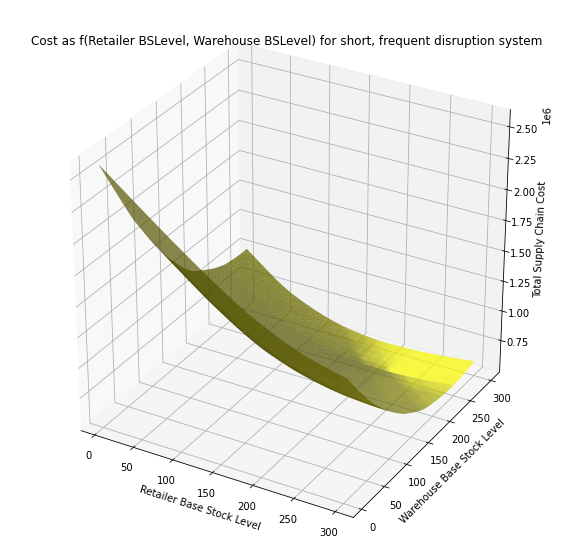

In [ ]:
# 3-D Plot for cost as a function of retailer base stock level and warehouse base stock level
x = np.array(retailerBaseStockList)
y = np.array(supplierBaseStockList)
z = np.array(totalCostList)

fig = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_trisurf(x, y, z, color='yellow')
ax.set_title('Cost as f(Retailer BSLevel, Warehouse BSLevel) for short, frequent disruption system')
ax.set_xlabel('Retailer Base Stock Level')
ax.set_ylabel('Warehouse Base Stock Level')
ax.set_zlabel('Total Supply Chain Cost')

fig = plt.gcf()
fig.set_size_inches(10, 10, forward=True)

plt.show()

In [ ]:
# Find the minimum of the above simulation

minTC = float('inf')
bestRetailerBS = 0
bestWholesalerBS = 0

for i in range(len(totalCostList)):
  if totalCostList[i] < minTC:
    minTC = totalCostList[i]
    bestRetailerBS = retailerBaseStockList[i]
    bestWholesalerBS = supplierBaseStockList[i]

print("Minimum Cost for this simulation")
print("Lowest Cost found: " + str(minTC))
print("Associated Retailer Base Stock Level: " + str(bestRetailerBS))
print("Associated Wholesaler Base Stock Level: " + str(bestWholesalerBS))

Minimum Cost for this simulation
Lowest Cost found: 523683.01892203663
Associated Retailer Base Stock Level: 218
Associated Wholesaler Base Stock Level: 250


### 3-D Plot of optimal total cost vs. alpha/beta in this instance

In [ ]:
# FINISHED NOV 15th, 2020

alphas = []
betas = []
optimalCosts = []
optimalRetailerBSLevels = []
optimalWholesalerBSLevels = []

# Simulate various values of alpha and beta for the system...
for alphaVal in range(0, 101, 5):
  alphaToUse = alphaVal/100
  for betaVal in range(0, 101, 5):
    betaToUse = betaVal/100

    totalCostList = []
    retailerBaseStockList = []
    supplierBaseStockList = []
    baseStockTestDict = {0: 60, 1: 60, 2: 60}

    # This actually runs different base stocks
    for j in range(10,201,10):
      for i in range(10,201,10):
        totalCost = 0
        baseStockTestDict = {0: i, 1: j, 2: j}

        # Create inventory simulation
        myInvSim = InvSimulation(periodsToSimulate=100)

        # Set up node tree
        myInvSim.createNode(nodeID = 0, h = 10, p = 10, alpha=alphaToUse, beta=betaToUse)
        myInvSim.createNode(nodeID = 1, h = 10, p = 10, alpha=alphaToUse, beta=betaToUse)
        myInvSim.createNode(nodeID = 2, h = 10, p = 10, alpha=alphaToUse, beta=betaToUse)

        myInvSim.linkNode(startNode = 0,endNode = 1)
        myInvSim.linkNode(startNode = 0,endNode = 2)

        myInvSim.playSimulation(gameType = "supplyDisruption", BSLevel=baseStockTestDict, demandMethod="useFileDemand", fileDemand=andCaseSnyderData["IO:EXT"], connectionCase="and", seed=42, printOut=False)

        #myInvSim.playSimulation(gameType = "supplyDisruption", BSLevel=baseStockTestDict, demandMethod="customDemand", customDemand=60, connectionCase="and", seed=42, printOut=False)

        for node in myInvSim.nodeDict.values():
          totalCost += sum(node.costRecord)
        totalCostList.append(totalCost)
        retailerBaseStockList.append(i)
        supplierBaseStockList.append(j)

    # Find the minimum after going through all of the imulations
    minTC = float('inf')
    bestRetailerBS = 0
    bestWholesalerBS = 0
    for i in range(len(totalCostList)):
      if totalCostList[i] < minTC:
        minTC = totalCostList[i]
        bestRetailerBS = retailerBaseStockList[i]
        bestWholesalerBS = supplierBaseStockList[i]

    # Record the data we're looking for (alpha, beta, optimalCost, optimalRetailerBSLevel, optimalWholesalerBSLevel)
    alphas.append(alphaToUse)
    betas.append(betaToUse)
    optimalCosts.append(minTC)
    optimalRetailerBSLevels.append(bestRetailerBS)
    optimalWholesalerBSLevels.append(bestWholesalerBS)

print("Simulations completed, data gathered")

#print("Minimum Cost for this simulation")
#print("Lowest Cost found: " + str(minTC))
#print("Associated Retailer Base Stock Level: " + str(bestRetailerBS))
#print("Associated Wholesaler Base Stock Level: " + str(bestWholesalerBS))

#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#surf = ax.scatter(np.array(retailerBaseStockList), np.array(supplierBaseStockList), np.array(totalCostList))

#ax.set_xlabel('Retailer Base Stock Level')
#ax.set_ylabel('Warehouse Base Stock Level')
#ax.set_zlabel('Total Supply Chain Cost')

#plt.show()

#------------------------------------------------------------------------------#

# 3-D Plot for cost as a function of retailer base stock level and warehouse base stock level
#x = np.array(retailerBaseStockList)
#y = np.array(supplierBaseStockList)
#z = np.array(totalCostList)

#fig = plt.figure()
#ax = plt.axes(projection='3d')
#surf = ax.plot_trisurf(x, y, z, color='yellow')
#ax.set_title('Cost as f(Retailer BSLevel, Warehouse BSLevel) for long, infrequent disruption system')
#ax.set_xlabel('Retailer Base Stock Level')
#ax.set_ylabel('Warehouse Base Stock Level')
#ax.set_zlabel('Total Supply Chain Cost')

#fig = plt.gcf()
#fig.set_size_inches(10, 10, forward=True)

#plt.show()

Simulations completed, data gathered


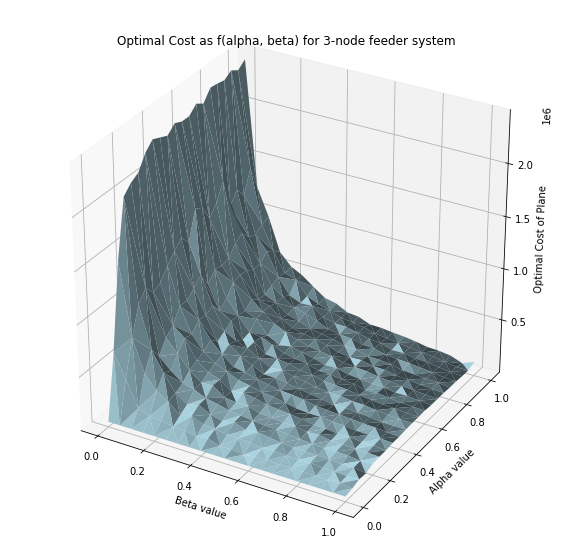

In [ ]:
# 3-D Plot for cost as a function of retailer base stock level and warehouse base stock level
x = np.array(betas)
y = np.array(alphas)
z = np.array(optimalCosts)

fig = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_trisurf(x, y, z, color='lightblue')
ax.set_title('Optimal Cost as f(alpha, beta) for 3-node feeder system')
ax.set_xlabel('Beta value')
ax.set_ylabel('Alpha value')
ax.set_zlabel('Optimal Cost of Plane')

fig = plt.gcf()
fig.set_size_inches(10, 10, forward=True)

plt.show()

In [ ]:
alphaBetaInvSim = pd.DataFrame({"alpha": alphas, "beta": betas, "optimalCost": optimalCosts, "optimalRetailerBS": optimalRetailerBSLevels, "optimalWholesalerBS": optimalWholesalerBSLevels})
alphaBetaInvSim.to_excel('experimentalAlphaBetaData.xlsx')

## Testing PiD values


In [ ]:
# Essentially, we're trying to solve the following question:
# Are longer, less frequent disruptions worse than frequent, short disruptions
# Answer:  It obviously depends upon how long and how frequent those disruptions are
#
# Test scenario 1:  longer, less frequent disruptions
# Test scenario 2:  shorter, more frequent disruptions

piDValues = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
testScenario1Alpha = [0.02, 0.03, 0.06, 0.08, 0.1, 0.15, 0.14, 0.08, 0.18]
testScenario1Beta = [0.18, 0.12, 0.14, 0.12, 0.1, 0.1, 0.06, 0.02, 0.02]
testScenario2Alpha = [0.09, 0.15, 0.3, 0.5, 0.6, 0.6, 0.7, 0.8, 0.81]
testScenario2Beta = [0.81, 0.6, 0.7, 0.75, 0.6, 0.4, 0.3, 0.2, 0.09]


In [ ]:
# FINISHED NOV 19th, 2020
# You can modify this as needed - Sean

optimalCostsSmallFrequentDisruptions = []
optimalCostsLongInfrequentDisruptions = []

# Simulate specified piD data values
for k in range(len(piDValues)):
  print("Now testing piD = " + str(piDValues[k]))
  for scenarioNumber in range(2):

    if scenarioNumber == 0: print("Long Infrequent Disruptions Testing...")
    elif scenarioNumber == 1: print("Short frequent Disruptions Testing...")

    totalCostList = []
    baseStockTestDict = {0: 60, 1: 60, 2: 60}

    # This actually runs different base stocks
    for j in range(10,301,5):
      for i in range(10,301,5):
        totalCost = 0
        baseStockTestDict = {0: i, 1: j, 2: j}

        # Create inventory simulation
        myInvSim = InvSimulation(periodsToSimulate=100)

        if scenarioNumber == 0:
          # Set up node tree for test 1
          myInvSim.createNode(nodeID = 0, h = 10, p = 50, alpha=testScenario1Alpha[k], beta=testScenario1Beta[k])
          myInvSim.createNode(nodeID = 1, h = 10, p = 50, alpha=0, beta=testScenario1Beta[k])
          myInvSim.createNode(nodeID = 2, h = 10, p = 50, alpha=0, beta=testScenario1Beta[k])
        elif scenarioNumber == 1:
          # Set up node tree for test 2
          myInvSim.createNode(nodeID = 0, h = 10, p = 50, alpha=testScenario2Alpha[k], beta=testScenario2Beta[k])
          myInvSim.createNode(nodeID = 1, h = 10, p = 50, alpha=0, beta=testScenario2Beta[k])
          myInvSim.createNode(nodeID = 2, h = 10, p = 50, alpha=0, beta=testScenario2Beta[k])

        myInvSim.linkNode(startNode = 0,endNode = 1)
        myInvSim.linkNode(startNode = 0,endNode = 2)

        myInvSim.playSimulation(gameType = "supplyDisruption", BSLevel=baseStockTestDict, demandMethod="useFileDemand", fileDemand=andCaseSnyderData["IO:EXT"], connectionCase="and", seed=42, printOut=False)

        # Append the total cost for future analysis
        for node in myInvSim.nodeDict.values():
          totalCost += sum(node.costRecord)
        totalCostList.append(totalCost)

    # Find the minimum after going through all of the simulations
    minTC = float('inf')
    bestRetailerBS = 0
    bestWholesalerBS = 0
    for i in range(len(totalCostList)):
      if totalCostList[i] < minTC:
        minTC = totalCostList[i]

    # Add the optimal cost to the correct scenario
    if scenarioNumber == 0: optimalCostsLongInfrequentDisruptions.append(minTC)
    elif scenarioNumber == 1: optimalCostsSmallFrequentDisruptions.append(minTC)

  print()
print("All Simulations completed, data gathered")

Now testing piD = 0.1
Long Infrequent Disruptions Testing...
Short frequent Disruptions Testing...

Now testing piD = 0.2
Long Infrequent Disruptions Testing...
Short frequent Disruptions Testing...

Now testing piD = 0.3
Long Infrequent Disruptions Testing...
Short frequent Disruptions Testing...

Now testing piD = 0.4
Long Infrequent Disruptions Testing...
Short frequent Disruptions Testing...

Now testing piD = 0.5
Long Infrequent Disruptions Testing...
Short frequent Disruptions Testing...

Now testing piD = 0.6
Long Infrequent Disruptions Testing...
Short frequent Disruptions Testing...

Now testing piD = 0.7
Long Infrequent Disruptions Testing...
Short frequent Disruptions Testing...

Now testing piD = 0.8
Long Infrequent Disruptions Testing...
Short frequent Disruptions Testing...

Now testing piD = 0.9
Long Infrequent Disruptions Testing...
Short frequent Disruptions Testing...

All Simulations completed, data gathered


In [ ]:
print(optimalCostsLongInfrequentDisruptions)

[551836.7282811274, 845209.9222080929, 848808.5017988542, 861433.9935117671, 1659524.4570258684, 1793520.2153050199, 2684619.8365188264, 4376479.099249526, 5741086.9397635665]


In [ ]:
print(optimalCostsSmallFrequentDisruptions)

[172159.52405179507, 301096.5947902692, 302895.7372872385, 300916.8048264616, 406551.28917788126, 543705.4680486928, 575219.7358390606, 1163883.5749961808, 2520649.8563028923]


In [ ]:
# Find out which type of disruption is better
for i in range(len(piDValues)):

  print("For piD = " + str(piDValues[i]))
  if optimalCostsLongInfrequentDisruptions[i] > optimalCostsSmallFrequentDisruptions[i]:
    print("Small frequent disruptions are optimal")
  else:
    print("Large infrequent disruptions are optimal")
  print()


For piD = 0.1
Small frequent disruptions are optimal

For piD = 0.2
Small frequent disruptions are optimal

For piD = 0.3
Small frequent disruptions are optimal

For piD = 0.4
Small frequent disruptions are optimal

For piD = 0.5
Small frequent disruptions are optimal

For piD = 0.6
Small frequent disruptions are optimal

For piD = 0.7
Small frequent disruptions are optimal

For piD = 0.8
Small frequent disruptions are optimal

For piD = 0.9
Small frequent disruptions are optimal



In [ ]:
# Export results to DF
columnsForPiDDF = ['piD', 'alpha1', 'beta1', 'cost1', 'alpha2', 'beta2', 'cost2']
piDExportDF = pd.DataFrame([piDValues, testScenario1Alpha, testScenario1Beta, optimalCostsLongInfrequentDisruptions, testScenario2Alpha, testScenario2Beta, optimalCostsSmallFrequentDisruptions], columnsForPiDDF)
piDExportDF.to_excel('piDOptimalityTesting100PeriodNode0Disrupted.xlsx')

## Excel Exports



### Export Last Run of Simulation Data

In [ ]:
# Export to Excel Method Demo:
def createExcelFile(myInvSim, fname):

  nodeDataDF = {}

  for node in myInvSim.nodeDict.values():
    nodeDataDF["node " + str(node.id) + " starting Inventory"] = node.startingInventoryRecord
    nodeDataDF["node " + str(node.id) + " receivedMats"] = node.receivedMats
    nodeDataDF["node " + str(node.id) + " backorders Fulfilled"] = node.backordersFulfilledArray
    nodeDataDF["node " + str(node.id) + " demand"] = node.demandArray
    nodeDataDF["node " + str(node.id) + " supply"] = node.supplyArray
    nodeDataDF["node " + str(node.id) + " backorders"] = node.backorderRecord
    nodeDataDF["node " + str(node.id) + " ending Inventory"] = node.endingInventoryRecord
    nodeDataDF["node " + str(node.id) + " order"] = node.orderArray
    nodeDataDF["node " + str(node.id) + " holding cost"] = node.holdingCostRecord
    nodeDataDF["node " + str(node.id) + " stockout cost"] = node.stockoutCostRecord
    nodeDataDF["node " + str(node.id) + " cost"] = node.costRecord

  nodeDataDF = pd.DataFrame(nodeDataDF)
  nodeDataDF.to_excel(fname)

In [ ]:
createExcelFile(myInvSim, "29OCT2020 - Sim Run 60-50-60 (revised run).xlsx")

### Surf Plot
Export of the x, y, and z values of the 3-D surf plot

In [ ]:
def createSurfExcelFile(x, y, z, fname):

  surfDataDF = {}

  surfDataDF["retailerBaseStock"] = x
  surfDataDF["warehouse1BaseStock"] = y
  surfDataDF["warehouse2BaseStock"] = y * 2
  surfDataDF["totalCost"] = z

  surfDataDF = pd.DataFrame(surfDataDF)
  surfDataDF.to_excel(fname)

In [ ]:
# Create the surf Excel file
createSurfExcelFile(x, y, z, "surfData.xlsx")

### 1-Node Newsvendor Cost vs. Base Stock Level Export
Excel export of the values of the 2-D total cost vs. base stock level plot (designed for 1 node)

In [ ]:
def printNewsvendorExcelFile(x, z, fname):

  newsvendorDataDF = {}

  newsvendorDataDF["retailer Base Stock"] = x
  newsvendorDataDF["total Cost Over 1000 Periods"] = z

  newsvendorDataDF = pd.DataFrame(newsvendorDataDF)
  newsvendorDataDF.to_excel(fname)

In [ ]:
printNewsvendorExcelFile(retailerBaseStockList, totalCostList, "newsvendorSim.xlsx")

## Miscellaneous Inventory Plots

In [ ]:
# Demand for Node 0 over time

pd0Demand = myInvSim.nodeDict[0].demandArray
print(pd0Demand)

pd = [i for i in range(len(pd0Demand))]

plt.scatter(pd, pd0Demand)
plt.plot(pd, pd0Demand)
plt.title("Starting Inventory Level + Inbound Supply for Node 0 vs. Period")
plt.xlabel("Period")
plt.ylabel("Starting Inventory + Inbound Supply for Node 0")
plt.show()

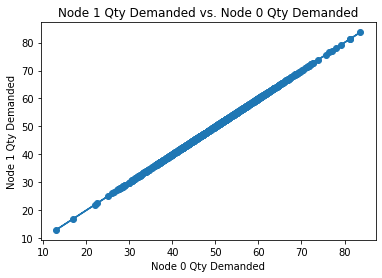

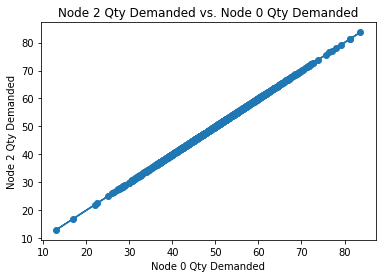

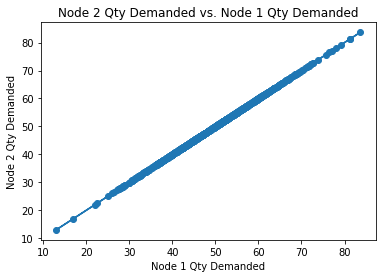

In [ ]:
# Demand for all nodes (3-node simulation) over time

node0Demand = myInvSim.nodeDict[0].demandArray
node1Demand = myInvSim.nodeDict[1].demandArray
node2Demand = myInvSim.nodeDict[2].demandArray

plt.scatter(node0Demand, node1Demand)
plt.plot(node0Demand, node1Demand)
plt.title("Node 1 Qty Demanded vs. Node 0 Qty Demanded")
plt.xlabel("Node 0 Qty Demanded")
plt.ylabel("Node 1 Qty Demanded")
plt.show()

plt.scatter(node0Demand, node2Demand)
plt.plot(node0Demand, node2Demand)
plt.title("Node 2 Qty Demanded vs. Node 0 Qty Demanded")
plt.xlabel("Node 0 Qty Demanded")
plt.ylabel("Node 2 Qty Demanded")
plt.show()

plt.scatter(node1Demand, node2Demand)
plt.plot(node1Demand, node2Demand)
plt.title("Node 2 Qty Demanded vs. Node 1 Qty Demanded")
plt.xlabel("Node 1 Qty Demanded")
plt.ylabel("Node 2 Qty Demanded")
plt.show()

In [ ]:
for node in myInvSim.nodeDict.values():
  cost = node.costRecord
  EI = node.endingInventoryRecord
  plt.scatter(EI, cost)
  plt.xlabel("Ending Inventory")
  plt.ylabel("Cost (this Period)")
  plt.title("Cost as a function of Ending Inventory for node " + str(node.id))
  plt.show()

## Notes / Tasks / TODO

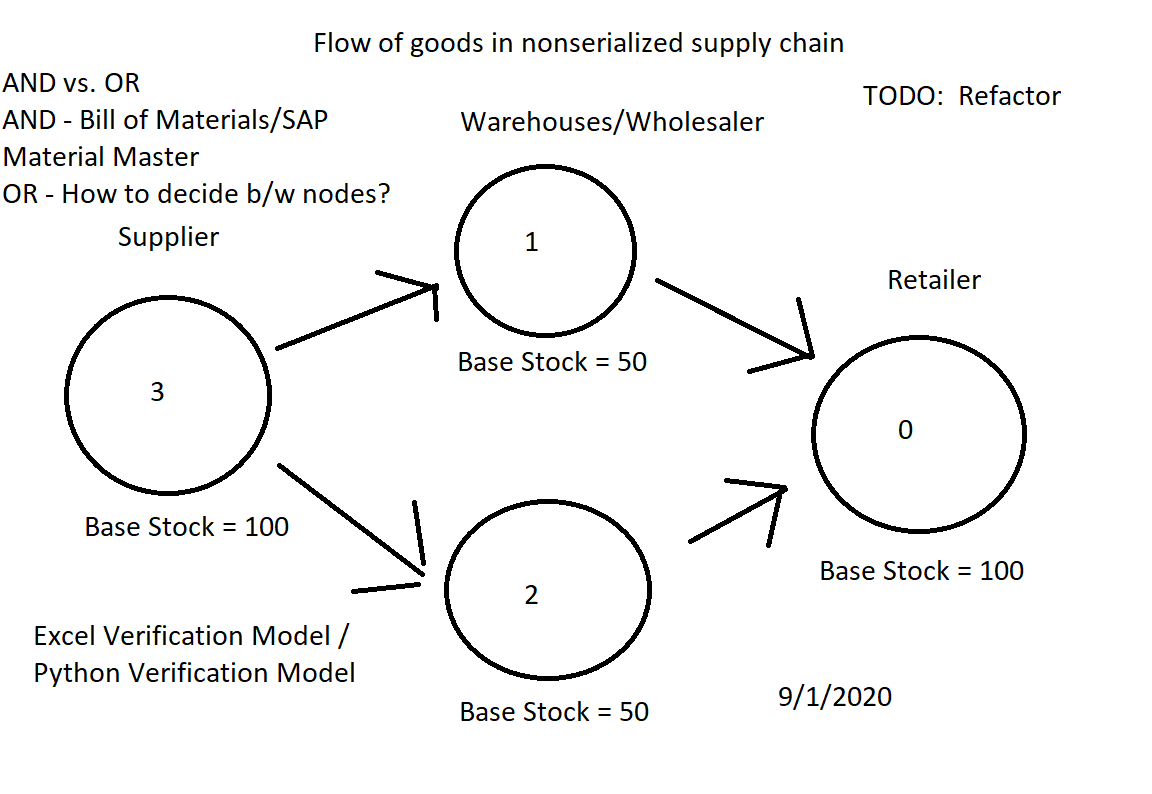

```
TODO:  15SEP2020



Things to do:
- Change base stock level for node 1 and node 2 to 50 (actually 30)
- Plot cost as a function of base stock level (see above, change up the nodes)
- AND case issue...  How to implement ordering?

'''

'''
Notes:
Total Cost as a function of base stock level
Allow user to specify base stock level for specific nodes

- Change one base stock level, keep other two constant, and plot the total SC cost
-> Rinse and repeat for the other nodes


AND siutation:
Node 1 has inventory of 100
Node 2 has inventory of 80
Can retailer see the inventory for both?

Node 0 orders what it needs, if extra stuff arrives, then it has to just let it sit there?

Implement using a dictionary w/ PreDict and RecDict values

Assume that node 1 and 2 have their inventories
If node 0 orders, node 0 doesn't have matching pairs, it needs to hang on to the extra

Right now nobody's selfish

Assembly Supply Chain:  ex: 0->1->2
There is an optimal policy

"Diamond" Supply chain (see image)

Distribution nodes screw things up, make the problems harder
-> Because of allocation
```



Notes for 22SEP2020:

Tasks TODO:
- Implement "and" case...  Taking longer than expected
- Find the minimum of that 3-D plot 


that compared the base stock level of the retailer vs. the wholesaler's costs
- Implement a random demand (that can take a seed)
 - Option in code "useRandomDemand" with optional parameter "seed"

-----------------------------------------------
    Oct 4: implement a dict: unitsReceivedDict[]


    At the end of period 0, we have to determine how much to order for node 0, node 1, and node 2
    Node 1 and node 2 receive those orders and do their best to fulfill them (i.e. populate their own supply arrays)

    Period 0 happens, we incur a demand of 60 at node 0, node 1 and node 2 need to figure out how to respond.  They see how much they can supply:
    Node 1 can supply 30
    Node 2 can supply 60

    They put these values in their supply array and then time passes forward to period 1

    PERIOD 1

    Now we're back to node 0

```
# This is formatted as code
```

.  We need to find out how many materials have been received.  Assume a 1:1 ratio and "AND relationships" between node 0 and 1
    and node 0 and 2

    We look at the supply array for node 1 and node 2, record those values in a "receivedMaterials" dictionary (part of node 0)
    This dictionary should have a key for each predecessor node (the predecessor's nodeID), and a value that represents the value the node was able to suply

    Node 0 looks at each of its predecessors' supply arrays.  It pulls 30 from node 1 and 60 from node 2
    We now have a receivedMaterials dictionary like so: {1: 30, 2: 60}

    Min value of the dict is 30.  Subtract 30 from each

    Now dictionary is: {1: 0, 2: 30}
    Add the 30 to node 0's inventory
    So, node 0 has a starting inventory level of 30 after receiving materials

    Let's say we that our period 1 demand is 60

    Node 0 inventory level goes down from 30 to -30. (now we need 90 finished units)

    Note that our base stock level is supposed to be 60.  Using this alone, we'd need to order 90.
    HOWEVER - we have orders already placed for 30 units, but those haven't been fulfilled yet because of node 1's low BS level
    We basically need to keep the inventory position at 60 instead of the inventory level

    Suppose that receivedMatsDict has {(1,30)}
    if node 0 has a demand of 60 units; adding the backorders to this, node 1 need to supply 90 units in total this period
    we need to deliver demand to node 1 = 30-90 = -60, demand to node 2: 0-90 = -90
    So, orders for this period will be:  60 from node 1, and 60 from node 2.
    Huh, so you wind up just ordering the demand


    '''

Notepad Log:
Running for 100 periods
SEED = 42
Node 1 and 2 are equivalent
Params: BS level of 60, 60, 60 (2-node feeder into node 0)
Using Snyder's demand from the "andCaseSnyderData" Excel file
alpha = [0]

Test 0.2 for alpha on all of the different nodes

No modification to alpha (alpha=0 on all)
Optimum:
50 BS Retailer
50 BS Wholesaler
Lowest Cost = 28,780

0.2 only on node 0
Optimum:
55 BS Retailer
50 BS Wholesaler
Lowest Cost = 34,425

0.2 on only node 1 (this is equivalent to node 2)
Optimum:
45 BS Retailer
55 BS Wholesaler
Lowest Cost = 34,814


0.2 on both node 1 and node 2
Optimum:
55 BS Retailer
50 BS Wholesaler
Lowest Cost = 39,276


0.2 on node 1, node 2, and node 0
Optimum:
50 BS Retailer
55 BS Wholesaler
Lowest Cost = 42,934


Surface becomes "crumpled" as we increase alpha and the instances of alpha


What happens when we change alpha to 0.5 for node 0, 1, and 2
Optimum:
65 BS Retailer
70 BS Wholesaler
Lowest Cost = 62,680
